# COMPSCI 7417 Applied Natural Language Processing
## Assignment 2 - Mini Project
## Data collection preprocessing visualisation

Group:
- Craig Atkinson a1669436 
- Lalitphan Sae-teoh a1932456 
- Pratham Maharjan a1944180 

### Import Libraries

In [107]:
import pandas as pd
import numpy as np
from pprint import pprint

import requests
import logging
import json
import time

import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO)

### Data Collection

In [76]:
# function to retrieve data from StackOverflow
def getData(page, tag):

    base_url = "https://api.stackexchange.com/2.3/questions"
    params = {
        "order": "asc",
        "sort": "creation",
        "tagged": tag,
        "site": "stackoverflow",
        "pagesize": 100,
        "page": page,
        "filter": "withbody",
        "key": "rl_7G8XRSxnP5ZMRRFLme9xurK36"
    }

    try:
        response = requests.get(base_url, params=params,timeout=(10, 10))
        response.raise_for_status()
        data = response.json()

        if "items" not in data or not data["items"]:
            logging.warning("No questions found.")
            return None

        data_list = []
        for question in data["items"]:
            accepted_answer=''
            accepted_answer_score=0
            answer_id = question.get("accepted_answer_id",None)
            time.sleep(0.1)
            if answer_id:
                answers_url = f"https://api.stackexchange.com/2.3/answers/{answer_id}"
                answers_params = {
                    "site": "stackoverflow",
                    "filter": "withbody",
                    "key": "rl_7G8XRSxnP5ZMRRFLme9xurK36" 
                }
                answers_response = requests.get(answers_url, params=answers_params, timeout=(10, 10))
                answers_response.raise_for_status()
                answer = answers_response.json().get('items', [])[0]

                accepted_answer=answer.get('body', '')
                accepted_answer_score=answer.get('score', 0)
                
                data_list.append([
                    question.get('title', ''),
                    question.get('body', ''),
                    ", ".join(question.get('tags', [])),
                    accepted_answer,
                    accepted_answer_score,
                    question.get('score', 0),
                    question.get('view_count', 0),
                    pd.to_datetime(question.get('creation_date'), unit='s'),
                    question.get('link','')
                ])


        df = pd.DataFrame(data_list, columns=["Title", "Description", "Tags", "Accepted Answer", "Answer Score", "Question Score", "Question Views", "Creation Time", "Link"])
        
        file_name = "questions_data_text.csv"

        with open(file_name, 'a', encoding='utf-8', newline='') as f:
              df.to_csv(f, header=None, encoding='utf-8', index=False)

    except requests.exceptions.RequestException as req_e:
        logging.error(f"Request failed: {req_e}")
    except json.JSONDecodeError as json_e:
         logging.error(f"Failed to decode JSON response: {json_e}")
    except Exception as e:
        logging.error(f"Unexpected error: {e}")
    return True

In [ ]:
#100 results for each page, total nlp questions: around 21,000
for page in range(1,100):
    result = getData(page,'nlp') # tag to query
    print(page)
    if result is None:
        break
    time.sleep(2)

When we queried 'nlp' tag for the first time , we queries all 20,581 questions provided 8,530 questions with accepted answers. We would like to get more related tages with only accepted answers. Therefore, we made some changes in the getData function to query only accepted answers and find the related tags by visualised the top 30 frequency tags with 'nlp' tag.

In [108]:
file_path = "./data/"
file_name_init = "questions_data_"

file_base_nlp = file_path + file_name_init + "nlp- Final.csv"
df = pd.read_csv(file_base_nlp, encoding="utf-8", header=0)
df.head()

,Title,Description,Tags,Accepted Answer,Answer Score,Question Score,Question Views,Creation Time,Link
0,Natural language date/time parser for .NET?,<p>Does anyone know of a .NET date/time parser...,".net, datetime, nlp",<p>We developed exactly what you are looking f...,12.0,27.0,6474.0,22/08/2008 22:45,https://stackoverflow.com/questions/23689/natu...
1,What&#39;s a good natural language library to ...,<p>I'm looking for an existing library to summ...,"language-agnostic, nlp",NaN,0.0,14.0,6488.0,24/08/2008 20:57,https://stackoverflow.com/questions/25332/what...
2,Vista speech recognition in multiple languages,"<p>my primary language is spanish, but I use a...","windows-vista, nlp, speech-recognition, multil...","<p>Citation from Vista <a href=""http://blogs.m...",8.0,3.0,5659.0,31/08/2008 1:08,https://stackoverflow.com/questions/36533/vist...
3,How do you implement a &quot;Did you mean&quot;?,<blockquote>\r\n <p><strong>Possible Duplicat...,nlp,<p>Actually what Google does is very much non-...,87.0,118.0,33169.0,3/09/2008 10:36,https://stackoverflow.com/questions/41424/how-...
4,Is there an algorithm that tells the semantic ...,"<p>input: phrase 1, phrase 2</p>\r\n\r\n<p>out...","algorithm, nlp, semantics",<hr>\r\n\r\n<p>You might want to check out thi...,44.0,65.0,49881.0,15/09/2008 12:26,https://stackoverflow.com/questions/62328/is-t...


In [109]:
data_cols = df.columns
print(f"All columns: {data_cols}")
print(f"Total NLP tag records: {len(df)}")

df.dropna(axis=0, inplace=True)
print(f"Total NLP tag records after remove no accepted answer: {len(df)}")

All columns: Index(['Title', 'Description', 'Tags', 'Accepted Answer', 'Answer Score',
       'Question Score', 'Question Views', 'Creation Time', 'Link'],
      dtype='object')
Total NLP tag records: 20581
Total NLP tag records after remove no accepted answer: 8540


32583


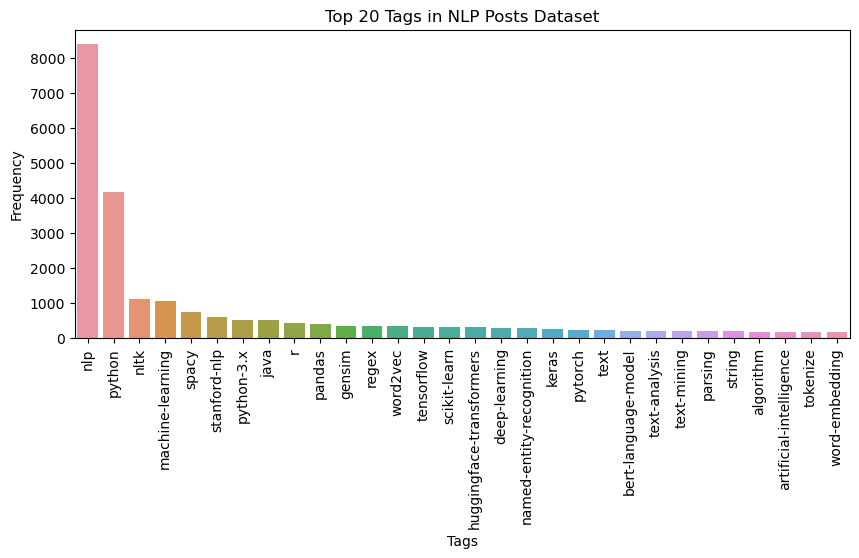

In [5]:
tags_list=[]

tags = df['Tags']

for question in tags:
    try:
        for each_tag in question.split(','):
            tags_list.append(each_tag.strip())
    except:
        pass
print(len(tags_list))

unique, counts = np.unique(np.array(tags_list), return_counts=True)

df_word_freq = pd.DataFrame({'Tags': unique,'Frequency': counts})

#the sort_values function will order the dataframe by frequency
df_word_freq = df_word_freq.sort_values('Frequency', ascending=False)

#seaborn library bar chart of the top 30 tokens
plt.figure(figsize=(10, 4))
sns.barplot(data=df_word_freq.head(30), x='Tags', y='Frequency')
plt.title('Top 20 Tags in NLP Posts Dataset')
plt.xticks(rotation=90)
plt.show()

We reran the getData with each related tags and save the file into csv format seperately.
Here are the tags that we selected : 
tag_list = ["nltk",
            "spacy",
            "stanford_nlp",
            "word2vec",
            "named_entity_recognition",
            "gensim",
            "bert_language_model",
            "text",
            "text_mining",
            "sentiment_analysis",
            "text_analysis",
            "word_embedding",
            "text_classification",
            "tokenize"]

### Merge all tags dataset and Remove Duplicates

In [84]:
tag_list = ["nltk",
            "spacy",
            "stanford_nlp",
            "word2vec",
            "named_entity_recognition",
            "gensim",
            "bert_language_model",
            "text",
            "text_mining",
            "sentiment_analysis",
            "text_analysis",
            "word_embedding",
            "text_classification",
            "tokenize"]

merge_df = df.copy()
for tag in tag_list:
    tag_file_name = file_path + file_name_init + tag + ".csv"
    df_tag = pd.read_csv(tag_file_name, encoding='utf-8', header=None)
    df_tag.columns = data_cols
    print(f"Total {tag} tag records: {len(df_tag)}")

    merge_df = pd.concat([merge_df, df_tag], ignore_index=True)
    merge_df.drop_duplicates(subset=["Link"], inplace=True)
    print(f"Total records after remove duplicates: {len(merge_df)}")
    print(f"--------------------------------------------------------")

Total nltk tag records: 3668
Total records after remove duplicates: 10735
--------------------------------------------------------
Total spacy tag records: 1629
Total records after remove duplicates: 11593
--------------------------------------------------------
Total stanford_nlp tag records: 1382
Total records after remove duplicates: 12300
--------------------------------------------------------
Total word2vec tag records: 956
Total records after remove duplicates: 12895
--------------------------------------------------------
Total named_entity_recognition tag records: 531
Total records after remove duplicates: 13010
--------------------------------------------------------
Total gensim tag records: 1109
Total records after remove duplicates: 13464
--------------------------------------------------------
Total bert_language_model tag records: 505
Total records after remove duplicates: 13760
--------------------------------------------------------
Total text tag records: 6416
Total r

In [ ]:
save_file_name = file_path + file_name_init + "nlp_combine_top_tags.csv"
merge_df.to_csv(save_file_name, encoding='utf-8', header=True, index=False)

In [63]:
merge_df = pd.read_csv(file_path + file_name_init + "nlp_combine_top_tags.csv", header=0, encoding='utf-8')
merge_df.head()

,Title,Description,Tags,Accepted Answer,Answer Score,Question Score,Question Views,Creation Time,Link
0,Natural language date/time parser for .NET?,<p>Does anyone know of a .NET date/time parser...,".net, datetime, nlp",<p>We developed exactly what you are looking f...,12.0,27.0,6474.0,22/08/2008 22:45,https://stackoverflow.com/questions/23689/natu...
1,Vista speech recognition in multiple languages,"<p>my primary language is spanish, but I use a...","windows-vista, nlp, speech-recognition, multil...","<p>Citation from Vista <a href=""http://blogs.m...",8.0,3.0,5659.0,31/08/2008 1:08,https://stackoverflow.com/questions/36533/vist...
2,How do you implement a &quot;Did you mean&quot;?,<blockquote>\r\n <p><strong>Possible Duplicat...,nlp,<p>Actually what Google does is very much non-...,87.0,118.0,33169.0,3/09/2008 10:36,https://stackoverflow.com/questions/41424/how-...
3,Is there an algorithm that tells the semantic ...,"<p>input: phrase 1, phrase 2</p>\r\n\r\n<p>out...","algorithm, nlp, semantics",<hr>\r\n\r\n<p>You might want to check out thi...,44.0,65.0,49881.0,15/09/2008 12:26,https://stackoverflow.com/questions/62328/is-t...
4,How to read values from numbers written as words?,<p>As we all know numbers can be written eithe...,"algorithm, language-agnostic, parsing, numbers...",<p>I was playing around with a PEG parser to d...,47.0,51.0,16255.0,16/09/2008 7:47,https://stackoverflow.com/questions/70161/how-...


Finally, we have total 23,289 records for posts related to nlp tag with accepted answers only.

### Data Collection - Analysis 

In [90]:
post_tag_list = ["nlp",
                "nltk",
                "spacy",
                "stanford-nlp",
                "word2vec",
                "named-entity-recognition",
                "gensim",
                "bert-language-model",
                "text",
                "text-mining",
                "sentiment-analysis",
                "text-analysis",
                "word-embedding",
                "text-classification",
                "tokenize"]

df_explode = merge_df.assign(Tags=merge_df.Tags.str.split(",")).explode('Tags')
df_explode['Tags'] = df_explode['Tags'].str.strip()
print("Records after explode: ", len(df_explode))

top_tag_explode = df_explode[df_explode['Tags'].isin(post_tag_list)]
print("Records after selecting only top tags: ", len(top_tag_explode))

Records after explode:  88389
Records after selecting only top tags:  29122


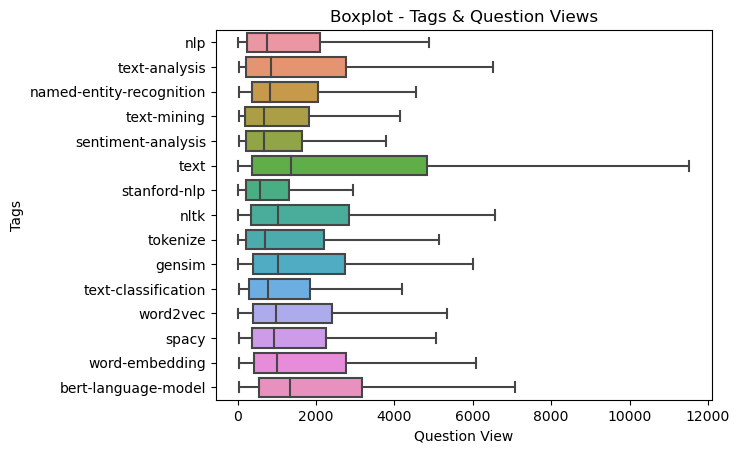

In [91]:
sns.boxplot(x = 'Question Views', y = 'Tags', data = top_tag_explode, showfliers=False)

plt.title('Boxplot - Tags & Question Views')
plt.xlabel('Question View')
plt.ylabel('Tags')
plt.show()

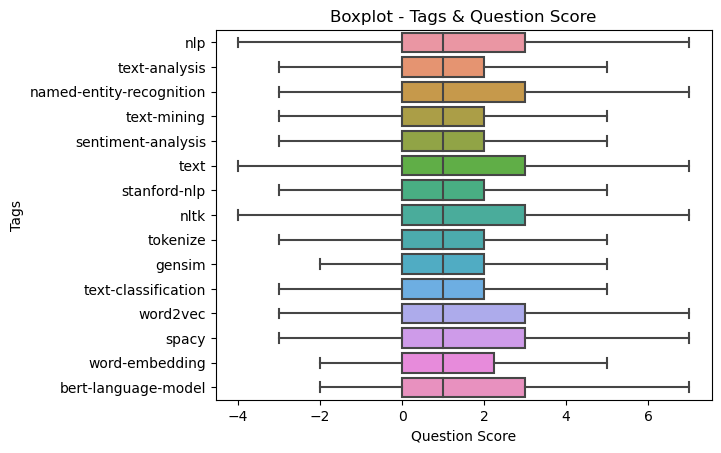

In [92]:
sns.boxplot(x = 'Question Score', y = 'Tags', data = top_tag_explode, showfliers=False)

plt.title('Boxplot - Tags & Question Score')
plt.xlabel('Question Score')
plt.ylabel('Tags')
plt.show()

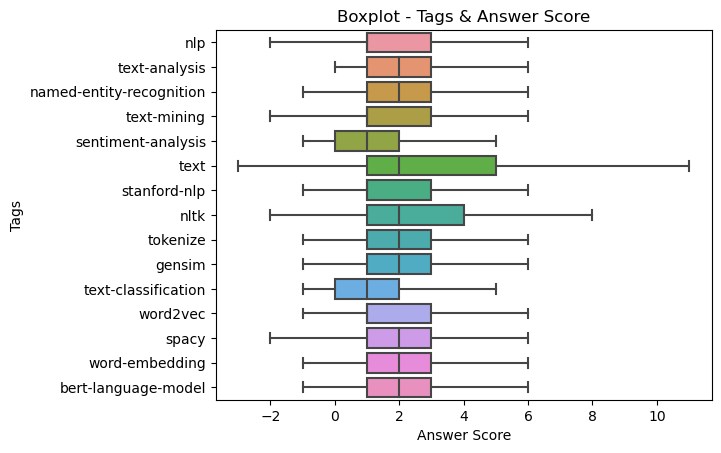

In [93]:
sns.boxplot(x = 'Answer Score', y = 'Tags', data = top_tag_explode, showfliers=False)

plt.title('Boxplot - Tags & Answer Score')
plt.xlabel('Answer Score')
plt.ylabel('Tags')
plt.show()

In [94]:
top_tag_explode.describe()

,Answer Score,Question Score,Question Views
count,29122.000000,29122.000000,2.912200e+04
mean,5.776183,4.026097,5.710628e+03
std,87.040328,49.646364,7.750179e+04
min,-8.000000,-10.000000,1.700000e+01
25%,1.000000,0.000000,2.980000e+02
50%,2.000000,1.000000,8.970000e+02
75%,3.000000,3.000000,2.609750e+03
max,13916.000000,7661.000000,1.174029e+07


In [106]:
top_tag_explode.groupby('Tags').agg({'Link': ['count'],
                                     'Question Views': ['mean','sum'],
                                     'Question Score': ['mean','sum'],
                                     'Answer Score': ['mean','sum']}).reset_index(level=0)

Tags  Link Question Views             Question Score  \
                             count           mean         sum           mean   
0        bert-language-model   505    3582.156436   1808989.0       2.263366   
1                     gensim  1109    3727.209197   4133475.0       2.760144   
2   named-entity-recognition   531    2118.047081   1124683.0       2.709981   
3                        nlp  8509    2995.220825  25486334.0       3.043601   
4                       nltk  3308    4767.238210  15770024.0       3.403869   
5         sentiment-analysis   679    2441.574374   1657829.0       1.860088   
6                      spacy  1629    3147.672192   5127558.0       2.640270   
7               stanford-nlp  1343    1646.588980   2211369.0       1.787789   
8                       text  6512   13587.572635  88482273.0       7.892813   
9              text-analysis   191    2955.455497    564492.0       2.869110   
10       text-classification   616    2410.173701   1484667.0       1.547078   
11               text-mining  1181    2719.723963   3211994.0       2.253175   
12                  tokenize  1605    6598.723988  10590952.0       4.128349   
13            word-embedding   448    3038.133929   1361084.0       3.058036   
14                  word2vec   956    3440.560669   3289176.0       3.060669   

            Answer Score           
        sum         mean      sum  
0    1143.0     2.990099   1510.0  
1    3061.0     3.843102   4262.0  
2    1439.0     3.408663   1810.0  
3   25898.0     3.936303  33494.0  
4   11260.0     4.923821  16288.0  
5    1263.0     2.751105   1868.0  
6    4301.0     3.560467   5800.0  
7    2401.0     2.630678   3533.0  
8   51398.0    12.056511  78512.0  
9     548.0     3.858639    737.0  
10    953.0     2.230519   1374.0  
11   2661.0     3.831499   4525.0  
12   6626.0     5.505296   8836.0  
13   1370.0     4.109375   1841.0  
14   2926.0     4.000000   3824.0

### Data Cleaning

In [110]:
import re
import contractions

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [111]:
#remove code blocks, urls, HTML code, special characters
def clean_text(text):

    #code blocks (text between code tag)
    text = re.sub(r'<code>.*?</code>', ' ', text, flags=re.DOTALL)

    #urls
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'https\S+', ' ', text)
    text = re.sub(r'<a.*?</a>', ' ', text)
    
    #other HTML tag
    text = re.sub(r'<.*?>', ' ', text)
    text = text.replace('&quot;', ' ')

    # contractions
    text = contractions.fix(text)
    
    #special characters and digits
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[\r\n]', ' ', text)
    
    #lowercase
    text = text.lower()

    #remove extra whitespaces
    text = text.strip()
    text = " ".join(text.split())

    return text

In [113]:
merge_df['Clean_Text_Init'] = (merge_df['Title'] + merge_df['Description']).apply(clean_text)
merge_df.head()

,Title,Description,Tags,Accepted Answer,Answer Score,Question Score,Question Views,Creation Time,Link,Clean_Text_Init
0,Natural language date/time parser for .NET?,<p>Does anyone know of a .NET date/time parser...,".net, datetime, nlp",<p>We developed exactly what you are looking f...,12.0,27.0,6474.0,22/08/2008 22:45,https://stackoverflow.com/questions/23689/natu...,natural language date time parser for net does...
1,Vista speech recognition in multiple languages,"<p>my primary language is spanish, but I use a...","windows-vista, nlp, speech-recognition, multil...","<p>Citation from Vista <a href=""http://blogs.m...",8.0,3.0,5659.0,31/08/2008 1:08,https://stackoverflow.com/questions/36533/vist...,vista speech recognition in multiple languages...
2,How do you implement a &quot;Did you mean&quot;?,<blockquote>\r\n <p><strong>Possible Duplicat...,nlp,<p>Actually what Google does is very much non-...,87.0,118.0,33169.0,3/09/2008 10:36,https://stackoverflow.com/questions/41424/how-...,how do you implement a did you mean possible d...
3,Is there an algorithm that tells the semantic ...,"<p>input: phrase 1, phrase 2</p>\r\n\r\n<p>out...","algorithm, nlp, semantics",<hr>\r\n\r\n<p>You might want to check out thi...,44.0,65.0,49881.0,15/09/2008 12:26,https://stackoverflow.com/questions/62328/is-t...,is there an algorithm that tells the semantic ...
4,How to read values from numbers written as words?,<p>As we all know numbers can be written eithe...,"algorithm, language-agnostic, parsing, numbers...",<p>I was playing around with a PEG parser to d...,47.0,51.0,16255.0,16/09/2008 7:47,https://stackoverflow.com/questions/70161/how-...,how to read values from numbers written as wor...


In [114]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if len(t) > 1]
    return ' '.join(tokens)

merge_df['Clean_Text_Init'] = merge_df['Clean_Text_Init'].apply(preprocess)

def remove_stop_words(text, stopwords):
  text = word_tokenize(text)
  return ' '.join([word for word in text if word not in stopwords])

def lemmatize(text):
  lemmatizer = WordNetLemmatizer()
  input_str = word_tokenize(text)
  new_words = []
  for word in input_str:
    new_words.append(lemmatizer.lemmatize(word))
  return ' '.join(new_words)

merge_df['Clean_Text_Stopword'] = merge_df['Clean_Text_Init'].apply(lambda s: remove_stop_words(s, stopwords.words('english')))
merge_df['Clean_Text_Stopword_Lemma'] = merge_df['Clean_Text_Stopword'].apply(lemmatize)


In [21]:
merge_df.drop(columns=['Tags', 'Accepted Answer', 'Answer Score', 'Question Score', 'Question Views'], inplace=True)
merge_df.head()

,Title,Description,Creation Time,Link,Clean_Text_Init,Clean_Text_Stopword,Clean_Text_Stopword_Lemma
0,Natural language date/time parser for .NET?,<p>Does anyone know of a .NET date/time parser...,22/08/2008 22:45,https://stackoverflow.com/questions/23689/natu...,natural language date time parser for net does...,natural language date time parser net anyone k...,natural language date time parser net anyone k...
1,Vista speech recognition in multiple languages,"<p>my primary language is spanish, but I use a...",31/08/2008 1:08,https://stackoverflow.com/questions/36533/vist...,vista speech recognition in multiple languages...,vista speech recognition multiple languages pr...,vista speech recognition multiple language pri...
2,How do you implement a &quot;Did you mean&quot;?,<blockquote>\r\n <p><strong>Possible Duplicat...,3/09/2008 10:36,https://stackoverflow.com/questions/41424/how-...,how do you implement did you mean possible dup...,implement mean possible duplicate suppose sear...,implement mean possible duplicate suppose sear...
3,Is there an algorithm that tells the semantic ...,"<p>input: phrase 1, phrase 2</p>\r\n\r\n<p>out...",15/09/2008 12:26,https://stackoverflow.com/questions/62328/is-t...,is there an algorithm that tells the semantic ...,algorithm tells semantic similarity two phrase...,algorithm tell semantic similarity two phrase ...
4,How to read values from numbers written as words?,<p>As we all know numbers can be written eithe...,16/09/2008 7:47,https://stackoverflow.com/questions/70161/how-...,how to read values from numbers written as wor...,read values numbers written words know numbers...,read value number written word know number wri...


In [22]:
merge_df.to_csv("./data/questions_data_clean_stopword_lemma_v4.csv", encoding='utf-8', header=True, index=False)

### Data Visualisation

In [115]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

In [116]:
merge_df['Cleaned_Title'] = merge_df['Title'].apply(clean_text)
merge_df['Cleaned_Title'] = merge_df['Cleaned_Title'].apply(preprocess)
print("Example of Cleaned Title: ", merge_df.iloc[3000]['Cleaned_Title'],"\nLink: ",df.iloc[3000]['Link'])
all_titles=' '.join(merge_df['Cleaned_Title'])

Example of Cleaned Title:  text mining removing contents if they are in another cell 
Link:  https://stackoverflow.com/questions/41710636/text-mining-removing-contents-if-they-are-in-another-cell


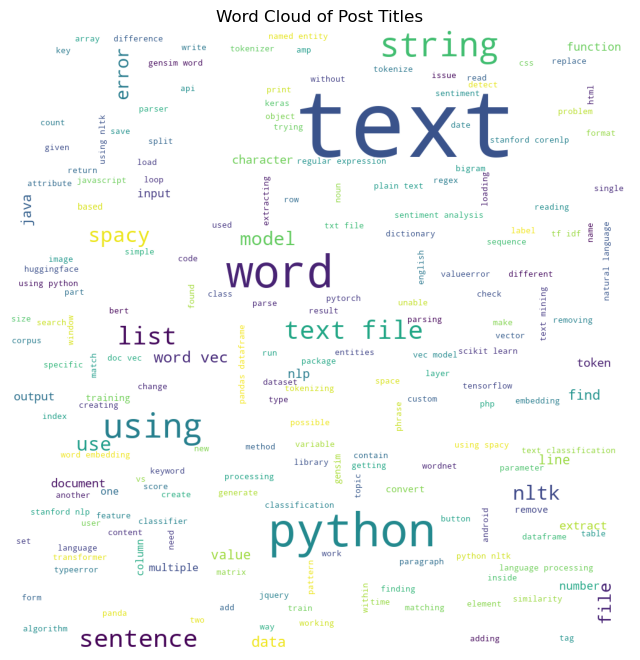

In [26]:
wordcloud = WordCloud(
    width=1000,
    height=1000,
    stopwords=None,
    background_color='white',
    max_words=200,
    min_font_size=10,
    max_font_size=150,
    relative_scaling=1,
    random_state=1
).generate(all_titles)

plt.figure(figsize=(8, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Post Titles')
plt.show()

In [123]:
merge_df['Cleaned_Title_Stopwords'] = merge_df['Cleaned_Title'].apply(lambda s: remove_stop_words(s, stopwords.words('english')))
print("Example of Cleaned Title Stopwords: ", merge_df.iloc[3000]['Cleaned_Title_Stopwords'],"\nLink: ",df.iloc[3000]['Link'])
clean_titles_stopwords =' '.join(merge_df['Cleaned_Title_Stopwords'])

Example of Cleaned Title Stopwords:  text mining removing contents another cell 
Link:  https://stackoverflow.com/questions/41710636/text-mining-removing-contents-if-they-are-in-another-cell


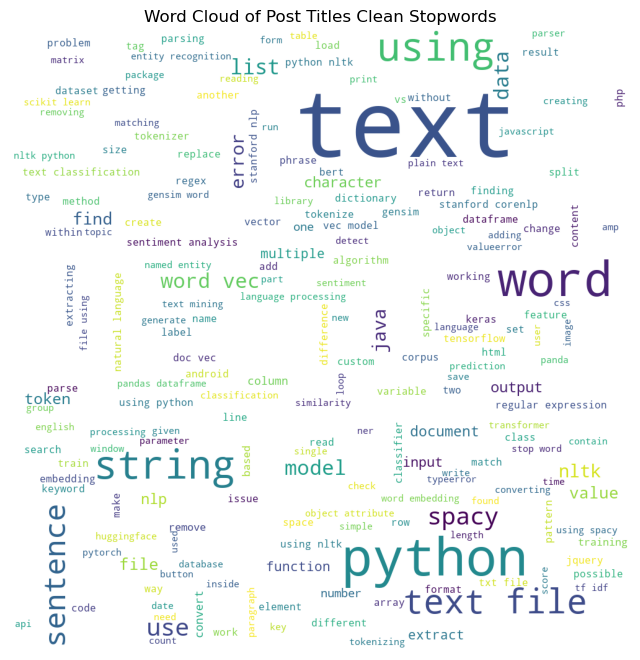

In [28]:
wordcloud = WordCloud(
    width=1000,
    height=1000,
    stopwords=None,
    background_color='white',
    max_words=200,
    min_font_size=1,
    max_font_size=150,
    relative_scaling=1,
    random_state=1
).generate(clean_titles_stopwords)

plt.figure(figsize=(8, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Post Titles Clean Stopwords')
plt.show()

Text(0.5, 1.0, 'Title Words Count')

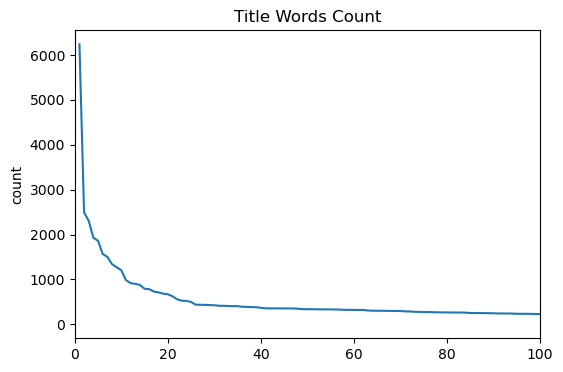

In [131]:
words = clean_titles_stopwords.split(" ")
cnt = Counter(words)
cnt_pd = pd.DataFrame(dict(cnt), index=[0]).transpose().sort_values([0], ascending=False)
cnt_pd.columns = ['count']

plt.figure(figsize=(6, 4))
sns.lineplot(y=cnt_pd['count'], x=range(1, len(cnt_pd)+1))
plt.xlim(0, 100)
plt.title('Title Words Count')

In [132]:
custom_stopwords = list(cnt_pd.head(5).index)
print(custom_stopwords)

['text', 'python', 'using', 'word', 'file']


### Custom remove common words

In [129]:
merge_df['Cleaned_Title_Stopwords_Custom'] = merge_df['Cleaned_Title_Stopwords'].apply(lambda s: remove_stop_words(s, stopwords=custom_stopwords))
print("Example of Cleaned Title Stopwords Lemma Custom: ", merge_df.iloc[3000]['Cleaned_Title_Stopwords_Custom'],"\nLink: ",df.iloc[3000]['Link'])
clean_titles_stopwords_custom =' '.join(merge_df['Cleaned_Title_Stopwords_Custom'])

Example of Cleaned Title Stopwords Lemma Custom:  mining removing content another cell 
Link:  https://stackoverflow.com/questions/41710636/text-mining-removing-contents-if-they-are-in-another-cell


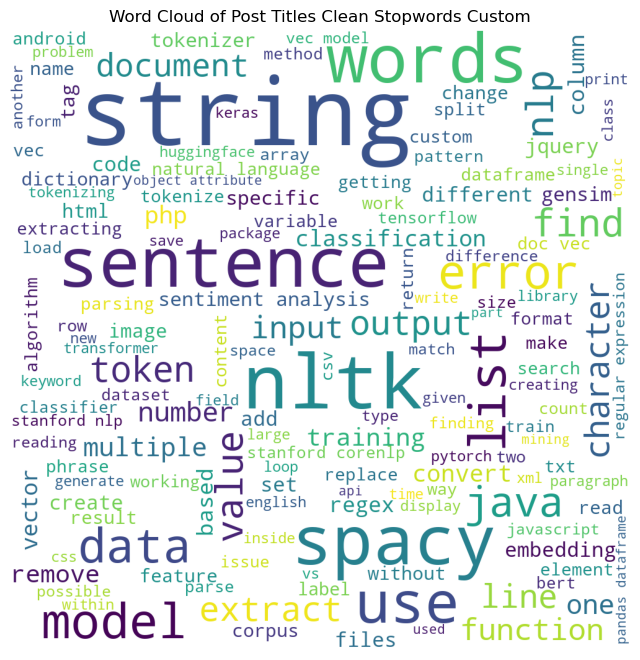

In [39]:
wordcloud = WordCloud(
    width=1000,
    height=1000,
    stopwords=None,
    background_color='white',
    max_words=150,
    min_font_size=10,
    max_font_size=150,
    relative_scaling=1,
    random_state=1
).generate(clean_titles_stopwords_custom)

plt.figure(figsize=(8, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Post Titles Clean Stopwords Custom')
plt.show()